# Punto 4

Repite el punto III, pero en lugar de usar tus embeddings, utiliza los embeddings preentrenados de Google-Word2Vec o Glove con diferentes dimensionalidades (al menos 3). Puedes descargar estos embeddings desde diferentes fuentes como el repositorio de datos de Gensim (Gensim Pretrained Models), la página web de Stanford (Stanford Glove Project), o TensorFlow Hub.

Importación de bibliotecas y dependencias a usar en el ejercicio

In [25]:
import os
import re
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import string
from sklearn.calibration import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd
import gensim.downloader
from gensim.models import KeyedVectors

A continuación, se cargan los embeddings preentrenados de GloVe (Global Vectors for Word Representation) utilizando la biblioteca Gensim. Los embeddings de GloVe son vectores numéricos que representan palabras, entrenados en grandes cantidades de texto para capturar relaciones semánticas entre palabras.

In [27]:
###############
## Glove pre-trained embeddings with different dimensionalities (at least 3)
###############
glove_vectors100 = gensim.downloader.load('glove-wiki-gigaword-100')
glove_vectors200 = gensim.downloader.load('glove-wiki-gigaword-200')
glove_vectors300 = gensim.downloader.load('glove-wiki-gigaword-300')

La siguiente implementación, carga los libros considerados desde un directorio, limpia su contenido eliminando secciones innecesarias, los divide en segmentos de palabras, y crea un dataset que puede ser usado para procesar un conjunto de libros del Proyecto Gutenberg y crear un dataset que pueda ser utilizado para entrenar los modelos considerados en el ejercicio.

In [28]:
###########
## CREANDO DATASET
###########

# Función para limpiar el texto del Proyecto Gutenberg
def clean_gutenberg_text(text):
    text = re.sub(r'^.*?\*\*\* START OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*', '', text, flags=re.DOTALL)
    text = re.sub(r'\*\*\* END OF THE PROJECT GUTENBERG EBOOK.*?$', '', text, flags=re.DOTALL)
    authors = r'William Oberfield|James Branch Cabell|Wilhelm Raabe'
    text = re.sub(r'(?i)\b(?:' + authors + r')\b.*?(?=\n)', '', text, flags=re.DOTALL)
    text = re.sub(r'(Produced by.*?Distributed Proofreaders|Title:.*?Author:.*?Release date:.*?Language:.*?Credits:.*?Project Gutenberg Distributed Proofreaders)', '', text, flags=re.DOTALL)
    text = re.sub(r'(CONTENTS.*?THE AFTERWORD|BIBLIOGRAPHY|INDEX)', '', text, flags=re.DOTALL)
    text = re.sub(r'\n+', '\n', text)
    text = text.strip()
    
    return text

# Función para dividir el texto en segmentos de longitud definida
def split_into_segments(text, segment_size=200):
    words = text.split() 
    segments = [' '.join(words[i:i + segment_size]) for i in range(0, len(words), segment_size)]
    return segments

# Función para cargar los datos de libros desde un directorio
def load_books_data(base_path='books', segment_size=200):
    texts = []
    labels = []
    authors = os.listdir(base_path)

    # Recorrer cada autor en el directorio
    for author in authors:
        author_path = os.path.join(base_path, author)
        # Recorrer cada archivo de libro del autor
        for book_file in os.listdir(author_path):
            # Leer el archivo de libro
            with open(os.path.join(author_path, book_file), 'r', encoding='utf-8') as f:
                book_text = f.read()
                clean_text = clean_gutenberg_text(book_text)
                segments = split_into_segments(clean_text, segment_size)
                texts.extend(segments)
                labels.extend([author] * len(segments))
    
    return texts, labels

# Función para crear un DataFrame a partir de los textos y etiquetas
def create_dataset(texts, authors):
    df = pd.DataFrame({'text': texts, 'author': authors})
    return df

# Cargar los libros y etiquetas
texts, labels = load_books_data()
# Crear un dataset con los textos y etiquetas
dataset = create_dataset(texts, labels)


Esta implementación, define tres arquitecturas diferentes de redes neuronales para el procesamiento de texto utilizando embeddings preentrenados. Estas redes están diseñadas para tareas de clasificación multiclase (probablemente con tres clases, dado que la capa de salida tiene 3 neuronas con activación softmax). A continuación, se desglosan cada uno de los modelos:

1. build_simple_model: Es el modelo más básico, con una capa de embeddings, una capa de promedio global, y dos capas densas antes de la salida.
2. build_deep_model: Es más profundo, con más capas densas, y utiliza Dropout para prevenir el sobreajuste.
3. build_batchnorm_model: Añade Batch Normalization para estabilizar el entrenamiento y mejorar la generalización.

Todos los modelos usan una arquitectura secuencial para clasificar los datos en 3 clases con softmax en la capa de salida.

In [1]:
############
## MODELOS 
############

# Construye un modelo simple con una capa de embeddings y algunas capas densas
def build_simple_model(vocab_size, embedding_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=200, weights=[embedding_matrix], trainable=False))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model , "simple"

# Construye un modelo más profundo con más capas densas y Dropout para regularización
def build_deep_model(vocab_size, embedding_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=200, weights=[embedding_matrix], trainable=False))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model, "deep"

# Construye un modelo con Batch Normalization y Dropout para mejorar la estabilidad del entrenamiento
def build_batchnorm_model(vocab_size, embedding_size, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=200, weights=[embedding_matrix], trainable=False))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization()) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model , "batchNorm"

Esta implementación, define una función para compilar y entrenar un modelo de redes neuronales en Keras, con la capacidad de almacenar el mejor modelo durante el proceso de entrenamiento. Esta, entrena el modelo, guarda la mejor versión según la precisión y retorna el historial de entrenamiento para análisis futuro.

In [30]:
#############
## FUNCIÓN DE COMPILACIÓN
#############
def compile_and_train_model(model, X_train, y_train, X_val, y_val, size, arquitectureLabel):
  # Compilar el modelo usando la pérdida de 'sparse_categorical_crossentropy' y el optimizador 'adam'
  model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
  )
  # Definir un callback para guardar el mejor modelo basado en la precisión durante el entrenamiento
  checkpoint_callback = ModelCheckpoint(
    f'best_model_{size}_{arquitectureLabel}.keras',
    monitor='accuracy',
    save_best_only=True,
    verbose=1 
  )

  # Entrenar el modelo con los datos de entrenamiento (X_train, y_train) y validación (X_val, y_val)
  history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=50, 
    batch_size=32,
    callbacks=[checkpoint_callback]
  )
  return history

Esta implementación, entrena tres arquitecturas de modelos de clasificación de texto utilizando embeddings preentrenados de GloVe con diferentes tamaños (100, 200, 300). Luego, evalúa el rendimiento de cada modelo en un conjunto de prueba, calculando precisión, recall y F1. Finalmente, guarda y muestra los resultados obtenidos, donde se ejecuta un proceso de entrenamiento y evaluación de modelos de clasificación de texto utilizando embeddings preentrenados de GloVe (100, 200 y 300 dimensiones) y tres arquitecturas de redes neuronales (simple, profunda y con BatchNorm).

In [31]:
####### 
## EJECUCIÓN
####### 

results = {} 
embeddings = {'100': glove_vectors100, '200': glove_vectors200, '300': glove_vectors300}  # Incluye 100 y 200 dimensiones

for size, glove_vector in embeddings.items():  # Ciclamos por cada embedding
    size = int(size)
    word2vecModel = glove_vector  # Usamos el embedding correspondiente
    vocab_size = len(word2vecModel.key_to_index)  # Tamaño del vocabulario
    tokenizer = Tokenizer(num_words=vocab_size)
    
    # Cargamos y procesamos los datos
    texts, labels = load_books_data()
    dataset = create_dataset(texts, labels)

    X_train, X_test, y_train, y_test = train_test_split(
        dataset['text'], dataset['author'], test_size=0.2, random_state=42)

    X_val, X_test, y_val, y_test = train_test_split(
        X_test, y_test, test_size=0.5, random_state=42)

    tokenizer.fit_on_texts(X_train)
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(y_train)
    y_val = encoder.transform(y_val)
    y_test = encoder.transform(y_test)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_val = tokenizer.texts_to_sequences(X_val)
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length = 200
    X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
    X_val = pad_sequences(X_val, maxlen=max_length, padding='post')
    X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

    # Construir la matriz de embeddings
    embedding_matrix = np.zeros((vocab_size, size))
    for word, index in word2vecModel.key_to_index.items():
        embedding_matrix[index] = word2vecModel[word]
    
    # Entrenar y evaluar cada arquitectura
    for modelToTrain in [build_simple_model, build_deep_model, build_batchnorm_model]:
        print(f"Entrenando con embeddings de tamaño: {size}")
        
        model, arquitectureLabel = modelToTrain(vocab_size, size, embedding_matrix)
        history = compile_and_train_model(model, X_train, y_train, X_val, y_val, size, arquitectureLabel)

        # Evaluación del modelo en el conjunto de prueba
        test_loss, test_accuracy = history.model.evaluate(X_test, y_test)
        
        # Predicciones
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calcular precisión, recall y f1
        precision = precision_score(y_test, y_pred_classes, average='weighted')
        recall = recall_score(y_test, y_pred_classes, average='weighted')
        f1 = f1_score(y_test, y_pred_classes, average='weighted')

        # Guardar los resultados
        results[f"{size}_{arquitectureLabel}"] = {
            "accuracy": test_accuracy,
            "loss": test_loss,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }

# Mostrar resultados finales
for size, metrics in results.items():
    print(f"Results for embeddings size {size}:")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1_score']}")


Entrenando con embeddings de tamaño: 100


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4267 - loss: 0.9962
Epoch 1: accuracy improved from -inf to 0.49728, saving model to best_model_100_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.4284 - loss: 0.9942 - val_accuracy: 0.5342 - val_loss: 0.8893
Epoch 2/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5138 - loss: 0.8108
Epoch 2: accuracy improved from 0.49728 to 0.52211, saving model to best_model_100_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.5144 - loss: 0.8107 - val_accuracy: 0.5404 - val_loss: 0.8861
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5952 - loss: 0.7997
Epoch 3: accuracy improved from 0.52211 to 0.61443, saving model to best_model_100_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.5957 - loss: 0.7994 - val_accuracy: 0.5404 - val_loss: 0.8589
Epoch 4/50
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5921 - loss: 0.7758 
Epoch 4: accuracy improved 

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4819 - loss: 0.9409
Epoch 1: accuracy improved from -inf to 0.50272, saving model to best_model_100_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.4843 - loss: 0.9340 - val_accuracy: 0.5342 - val_loss: 0.8827
Epoch 2/50
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5075 - loss: 0.8376
Epoch 2: accuracy improved from 0.50272 to 0.50349, saving model to best_model_100_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5068 - loss: 0.8389 - val_accuracy: 0.5342 - val_loss: 0.8809
Epoch 3/50
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5204 - loss: 0.8387
Epoch 3: accuracy improved from 0.50349 to 0.53530, saving model to best_model_100_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5217 - loss: 0.8377 - val_accuracy: 0.5342 - val_loss: 0.8780
Epoch 4/50
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5648 - loss: 0.8085
Epoch 4: accuracy improved from 0.535

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3818 - loss: 1.3453
Epoch 1: accuracy improved from -inf to 0.42514, saving model to best_model_100_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.3898 - loss: 1.3192 - val_accuracy: 0.3913 - val_loss: 1.0014
Epoch 2/50
33/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5779 - loss: 0.9298
Epoch 2: accuracy improved from 0.42514 to 0.64469, saving model to best_model_100_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5912 - loss: 0.9061 - val_accuracy: 0.5342 - val_loss: 0.9450
Epoch 3/50
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7349 - loss: 0.6932
Epoch 3: accuracy improved from 0.64469 to 0.74864, saving model to best_model_100_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7370 - loss: 0.6856 - val_accuracy: 0.7640 - val_loss: 0.8422
Epoch 4/50
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7539 - loss: 0.6055
Epoch 4: accuracy did 

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Entrenando con embeddings de tamaño: 200


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
31/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5006 - loss: 0.9719
Epoch 1: accuracy improved from -inf to 0.60047, saving model to best_model_200_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.5229 - loss: 0.9468 - val_accuracy: 0.5342 - val_loss: 0.8648
Epoch 2/50
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5990 - loss: 0.7707
Epoch 2: accuracy improved from 0.60047 to 0.67804, saving model to best_model_200_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6128 - loss: 0.7651 - val_accuracy: 0.7143 - val_loss: 0.7753
Epoch 3/50
32/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8034 - loss: 0.6533
Epoch 3: accuracy improved from 0.67804 to 0.79907, saving model to best_model_200_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.8015 - loss: 0.6501 - val_accuracy: 0.7702 - val_loss: 0.6891
Epoch 4/50
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7717 - loss: 0.5852
Epoch 4: accuracy improved 

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4780 - loss: 0.9367
Epoch 1: accuracy improved from -inf to 0.49806, saving model to best_model_200_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.4817 - loss: 0.9263 - val_accuracy: 0.5342 - val_loss: 0.8572
Epoch 2/50
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5560 - loss: 0.8265
Epoch 2: accuracy improved from 0.49806 to 0.61133, saving model to best_model_200_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.5664 - loss: 0.8156 - val_accuracy: 0.7267 - val_loss: 0.7923
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7572 - loss: 0.6516
Epoch 3: accuracy improved from 0.61133 to 0.76649, saving model to best_model_200_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7574 - loss: 0.6506 - val_accuracy: 0.7888 - val_loss: 0.5891
Epoch 4/50
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8200 - loss: 0.5006
Epoch 4: accuracy improved from 0.

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1268 - loss: 2.0527
Epoch 1: accuracy improved from -inf to 0.20481, saving model to best_model_200_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.1287 - loss: 2.0446 - val_accuracy: 0.6460 - val_loss: 0.9819
Epoch 2/50
34/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5413 - loss: 0.9454
Epoch 2: accuracy improved from 0.20481 to 0.62839, saving model to best_model_200_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.5567 - loss: 0.9313 - val_accuracy: 0.7826 - val_loss: 0.8907
Epoch 3/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7806 - loss: 0.6400 
Epoch 3: accuracy improved from 0.62839 to 0.79209, saving model to best_model_200_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.7815 - loss: 0.6382 - val_accuracy: 0.7267 - val_loss: 0.8473
Epoch 4/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8187 - loss: 0.5316
Epoch 4: accuracy 

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Entrenando con embeddings de tamaño: 300


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5103 - loss: 0.9865
Epoch 1: accuracy improved from -inf to 0.54538, saving model to best_model_300_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 0.5127 - loss: 0.9805 - val_accuracy: 0.8075 - val_loss: 0.8442
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7071 - loss: 0.7614
Epoch 2: accuracy improved from 0.54538 to 0.69899, saving model to best_model_300_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.7070 - loss: 0.7608 - val_accuracy: 0.8137 - val_loss: 0.7727
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7922 - loss: 0.6721
Epoch 3: accuracy improved from 0.69899 to 0.81071, saving model to best_model_300_simple.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.7927 - loss: 0.6711 - val_accuracy: 0.8137 - val_loss: 0.6662
Epoch 4/50
36/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8032 - loss: 0.5799
Epoch 4: accuracy improved

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4874 - loss: 0.9324
Epoch 1: accuracy improved from -inf to 0.52754, saving model to best_model_300_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.4937 - loss: 0.9204 - val_accuracy: 0.4037 - val_loss: 0.9125
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5455 - loss: 0.8163
Epoch 2: accuracy improved from 0.52754 to 0.61753, saving model to best_model_300_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.5472 - loss: 0.8152 - val_accuracy: 0.7516 - val_loss: 0.7368
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7658 - loss: 0.6044
Epoch 3: accuracy improved from 0.61753 to 0.78355, saving model to best_model_300_deep.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - accuracy: 0.7662 - loss: 0.6037 - val_accuracy: 0.8012 - val_loss: 0.5604
Epoch 4/50
37/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8243 - loss: 0.4695
Epoch 4: accuracy improved from

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4332 - loss: 1.1896
Epoch 1: accuracy improved from -inf to 0.55547, saving model to best_model_300_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 426ms/step - accuracy: 0.4446 - loss: 1.1707 - val_accuracy: 0.5342 - val_loss: 0.9520
Epoch 2/50
38/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7452 - loss: 0.6753
Epoch 2: accuracy improved from 0.55547 to 0.74399, saving model to best_model_300_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.7450 - loss: 0.6727 - val_accuracy: 0.8012 - val_loss: 0.8606
Epoch 3/50
35/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8068 - loss: 0.5112
Epoch 3: accuracy improved from 0.74399 to 0.80217, saving model to best_model_300_batchNorm.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.8059 - loss: 0.5129 - val_accuracy: 0.7950 - val_loss: 0.8266
Epoch 4/50
39/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8189 - loss: 0.4876
Epoch 4: accura

Se realiza la evidencia de las metricas de evaluación para cada modelo considerando las dimensiones parametrizadas en un dataframe

In [32]:
import pandas as pd

# Convertir los resultados a un DataFrame
df_results = pd.DataFrame(results).T

# Mostrar el DataFrame
pd.DataFrame(df_results)

,accuracy,loss,precision,recall,f1_score
100_simple,0.901235,0.291391,0.876798,0.901235,0.887038
100_deep,0.907407,0.237394,0.882532,0.907407,0.893171
100_batchNorm,0.802469,0.463522,0.822995,0.802469,0.780377
200_simple,0.938272,0.208503,0.935819,0.938272,0.935425
200_deep,0.944444,0.177741,0.943873,0.944444,0.943444
200_batchNorm,0.895062,0.346304,0.877732,0.895062,0.879973
300_simple,0.944444,0.153524,0.945425,0.944444,0.943052
300_deep,0.919753,0.220006,0.924569,0.919753,0.919814
300_batchNorm,0.938272,0.207567,0.938322,0.938272,0.938258


Finalmente, se generan las graficas de evaluación de metricas de los modelos considerados

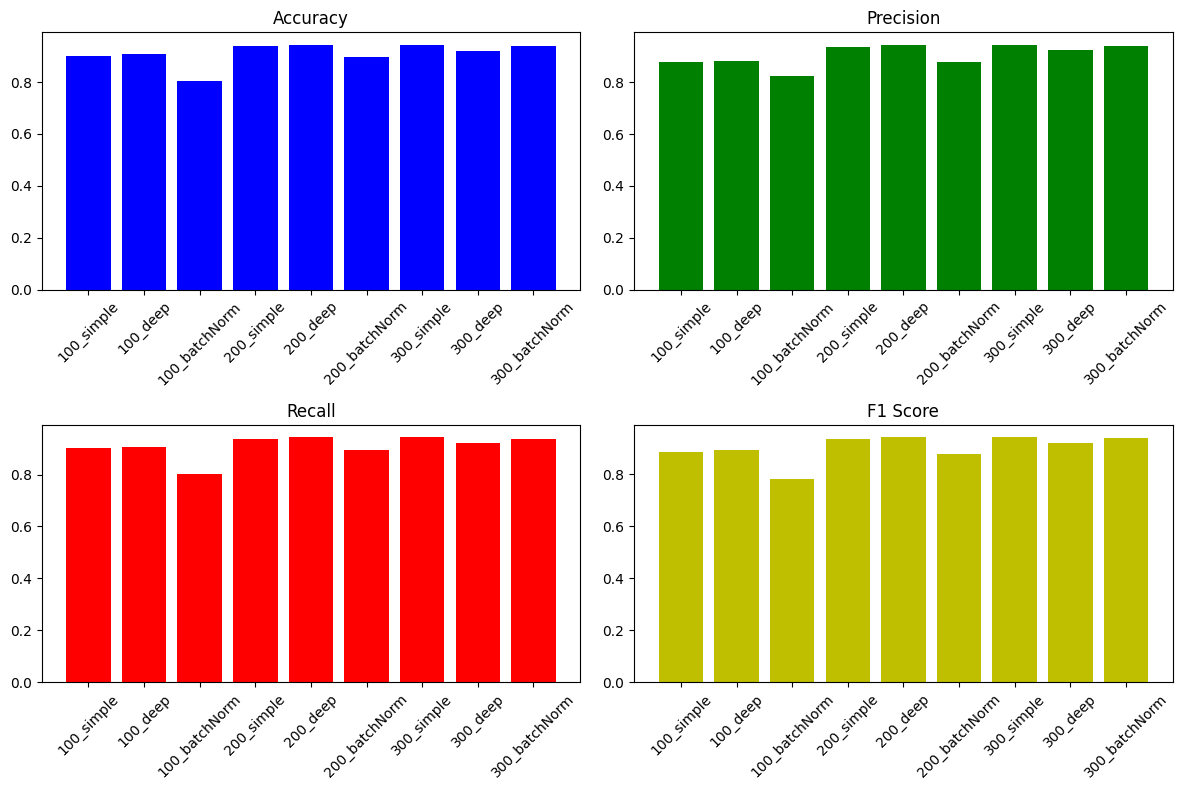

In [33]:
import matplotlib.pyplot as plt

# Función para graficar los resultados
def plot_metrics(results):
    # Extraer los tamaños de embedding y arquitecturas
    sizes = list(results.keys())
    accuracies = [results[size]["accuracy"] for size in sizes]
    precisions = [results[size]["precision"] for size in sizes]
    recalls = [results[size]["recall"] for size in sizes]
    f1_scores = [results[size]["f1_score"] for size in sizes]

    # Crear la figura y los ejes para las gráficas
    plt.figure(figsize=(12, 8))

    # Graficar la métrica de exactitud
    plt.subplot(2, 2, 1)
    plt.bar(sizes, accuracies, color='b')
    plt.title('Accuracy')
    plt.xticks(rotation=45)

    # Graficar la métrica de precisión
    plt.subplot(2, 2, 2)
    plt.bar(sizes, precisions, color='g')
    plt.title('Precision')
    plt.xticks(rotation=45)

    # Graficar la métrica de recall
    plt.subplot(2, 2, 3)
    plt.bar(sizes, recalls, color='r')
    plt.title('Recall')
    plt.xticks(rotation=45)

    # Graficar la métrica de F1 Score
    plt.subplot(2, 2, 4)
    plt.bar(sizes, f1_scores, color='y')
    plt.title('F1 Score')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Graficar resultados
plot_metrics(results)